In [1]:
import numpy as np
import pandas as pd
import datetime as dt
import psycopg2
import pipeline_plan_functions.utils.pipe_db_handler as dbh
import pipeline_plan_functions.utils.data_types as dth
from python_utils.utils.logger import logger
import alloc_functions.feasibility_functions as ff
import pipeline_plan_functions.utils.data_handler as dh
import matplotlib.pyplot as plt
# import matplotlib.dates as mdates
import matplotlib
import pickle
# import plotly.graph_objects as go
mapbox_token = ('pk.eyJ1Ijoic29mZmZ0IiwiYSI6ImNrbmZ0Z3RidzJ5NngycXA5cDNpY2c1ajIifQ.Gi2oP1Z3G5wP6pn7OF5l1A')
FPS_COLOURS = ['#004A9C', '#45D281', '#FEC001', '#A365E0', '#5B9BD5',
               '#FF0000', '#0563C1', '#954F72']

In [2]:
specs = (101, 102, 115, 116, 117)
good_sites = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 17, 20, 22, 28]
tru_spec_dict = {
    101: 1,
    102: 2,
    115: 3,
    116: 4,
    117: 5
}
MAX_SHOREPOWER_HOURS = 5.38  # hours
CHARGER_EFF = 0.9
BATTERY_USABLE = 0.8
DEFAULT_WAIT = 8  # HOURS
tru_battery_kwh = [30*BATTERY_USABLE, 24*BATTERY_USABLE, 19*BATTERY_USABLE, 14*BATTERY_USABLE]
tru_battery_dict = {'Future': 30*BATTERY_USABLE, 'Long range': 24*BATTERY_USABLE,
                    'Medium range': 19*BATTERY_USABLE, 'Short range': 14*BATTERY_USABLE}
tru_charger_kw = 9
remove_charging_time = 0.5
vehicle_specifications = ff.find_vehicle_spec(specs)
vehicle_specifications['kwh_mile'] = 0
vehicle_specifications['diesel_l_mile'] = 0
elec_vehicles = vehicle_specifications['fuel_type'] == 'electric'
diesel_vehicles = vehicle_specifications['fuel_type'] == 'diesel'
vehicle_specifications.loc[elec_vehicles, 'kwh_mile'] = vehicle_specifications.loc[elec_vehicles, 'energy_use']
vehicle_specifications.loc[diesel_vehicles, 'diesel_l_mile'] = vehicle_specifications.loc[diesel_vehicles, 'energy_use']
tru_specs = ff.find_tru_spec((1, 2, 3, 4, 5))
vehicle_specifications['tru_id'] = vehicle_specifications.index.map(tru_spec_dict)
vehicle_specifications = vehicle_specifications.reset_index()
vehicle_specifications = vehicle_specifications.merge(
    tru_specs,
    left_on='tru_id', right_on='tru_id', how='left')
vehicle_specifications = vehicle_specifications.set_index('spec_id')
good_specs = vehicle_specifications['vehicle_model'].to_dict()
site_dict = ff.get_site_name_dict(2)

### Get Routes

In [3]:
cnx = dbh.create_alch_engine()
site_dict = ff.get_site_name_dict(2)
sql_query = f"SELECT * FROM t_route_master WHERE client_id = 3"
routes = pd.read_sql_query(sql_query, con=cnx)
sql_query = f"SELECT * FROM t_vehicles WHERE client_id=2"
vehicle_df = pd.read_sql_query(sql_query, con=cnx, index_col='vehicle_id')
vehicle_spec_dict = vehicle_df['spec_id'].to_dict()
routes['spec_id'] = routes['vehicle_id'].map(vehicle_spec_dict)
routes = routes[routes['spec_id'].isin(good_specs.keys())].copy()
routes['good_site'] = ((routes['site_id_start'].isin(good_sites))
                       & (routes['site_id_end'].isin(good_sites)))
routes.sort_values(by=['vehicle_id', 'departure_time'], inplace=True)
# Create vehicle specification table
# connection, cur = dbh.database_connection('test')

In [4]:
sheet_list = pd.read_csv(r'C:\Users\SofiaTaylor\OneDrive - Flexible Power Systems Ltd\dev\fps_pipeline_plan\functions\shared_functions\telematics\sample\hgv\telematics_check.csv')
vehicles = sheet_list['vehicle_id'].unique()
vehicle_site_dict = {v: sheet_list[sheet_list['vehicle_id'] == v]['site_id'].values for v in vehicles}
routes['site_ids'] = routes['vehicle_id'].map(vehicle_site_dict)
routes['same_return'] = routes['site_id_start'] == routes['site_id_end']
routes['start_right_id'] = False
routes['duration_hours'] = (routes['arrival_time'] - routes['departure_time']).dt.total_seconds()/3600
routes['date'] = routes['departure_time'].dt.date
routes['start_time'] = (routes['departure_time'] - dt.datetime(2022, 1, 1)).dt.total_seconds()/3600 % 24
routes['end_time'] = (routes['arrival_time'] - dt.datetime(2022, 1, 1)).dt.total_seconds()/3600 % 24
routes['last_wait_onsite'] = (routes['departure_time']
                              - routes['arrival_time'].shift(1)).dt.total_seconds()/3600
routes['next_wait_onsite'] = (routes['departure_time'].shift(-1)
                              - routes['arrival_time']).dt.total_seconds()/3600
routes['week'] = routes['departure_time'].dt.isocalendar()['week']
mask_change_veh = routes['vehicle_id'] != routes['vehicle_id'].shift(1)
routes.loc[mask_change_veh, 'last_wait_onsite'] = 0
mask_change_veh = routes['vehicle_id'] != routes['vehicle_id'].shift(-1)
routes.loc[mask_change_veh, 'next_wait_onsite'] = 0
routes.drop(columns=['payload', 'number_crates', 'client_id'], inplace=True)
for idx in routes.index:
    routes.loc[idx, 'start_right_id'] = ff.right_start_site(
        routes.loc[idx, 'site_id_start'], routes.loc[idx, 'site_ids'])

# for spec in good_specs:
#     spec_routes = routes[routes['spec_id'] == spec]
#     bar_plot_site_ends(spec_routes, site_dict, site, suff=str(spec))

spec_stats = 100*routes.groupby('spec_id')[['same_return']].mean().round(3)
spec_stats['vehicle_type'] = spec_stats.index.map(good_specs)

In [6]:
count_routes_per_day = routes.groupby(['spec_id', 'vehicle_id', 'date'])[['client_id']].count()
avg_per_spec = count_routes_per_day.groupby('spec_id').mean()
times_per_spec = routes.groupby('spec_id').agg({
    'duration_hours': ['median', ff.q75, ff.q95],
    'last_wait_onsite': ['median', ff.q25, ff.q05]})
times_per_spec.columns = ['median_duration_hours', '75th_duration_hours', '95th_duration_hours',
                          'median_wait_hours', '25th_wait_hours', '5th_wait_hours']
avg_per_spec = avg_per_spec.merge(times_per_spec, left_index=True, right_index=True)
avg_per_spec.rename(columns={'client_id': 'routes_per_day_per_vehicle'}, inplace=True)
avg_per_spec.to_csv('sample/tru/spec_averages.csv')

KeyError: "Columns not found: 'client_id'"

### Cleanup routes

(array([  42.,   80.,  126.,  150.,  177.,  249.,  473.,  911., 1395.,
        2429.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

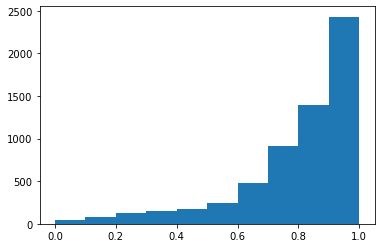

In [5]:
vehicle_good_sites = routes.groupby('vehicle_id')['good_site'].mean()
frequent_vehicles = vehicle_good_sites.loc[vehicle_good_sites > 0.6].index
plt.hist(vehicle_good_sites, cumulative=True)

In [6]:
print(len(routes)) # 213716

213716


In [7]:
cols = ['site_id_start', 'site_id_end', 'departure_time', 'arrival_time',
       'vehicle_id', 'distance_miles', 'route_id',
       'number_order', 'driving_time', 'duration_hours', 'date',
       'start_time', 'end_time', 'last_wait_onsite', 'next_wait_onsite',
       'week', 'good_site']
# Either started from a real depot or were in another site for short time
mask_good_start = ((routes['site_id_start'].isin(good_sites))
                   | (routes['last_wait_onsite'] < 3))
# Belong to a vehicle that operates mostly in the depots
mask_good_vehicles = routes['vehicle_id'].isin(frequent_vehicles)
mask_decent_wait = routes['next_wait_onsite'] >= 1
mask_good_end = routes['site_id_end'].isin(good_sites)
routes_cleaned = routes[mask_good_start & mask_good_vehicles
                        & mask_decent_wait & mask_good_end].copy()
# routes_cleaned[cols]

In [8]:
n_routes = len(routes_cleaned)
new_n_routes = 0
while n_routes != new_n_routes:
    n_routes = len(routes_cleaned)
    end_routes = ff.edge_routes(routes_cleaned)
    routes_cleaned = routes_cleaned.merge(end_routes, how='left', left_on=['vehicle_id', 'departure_time'], right_on=['vehicle_id', 'date_edge'])
    routes_cleaned['edge_routes'] = routes_cleaned['edge_routes'].fillna(False)
    routes_cleaned = routes_cleaned[(routes_cleaned['good_site']) | (~routes_cleaned['edge_routes'])]
    new_n_routes = len(routes_cleaned)
    print(n_routes, new_n_routes)
    routes_cleaned.drop(columns=['date_edge', 'edge_routes'], inplace=True)
end_routes = ff.edge_routes(routes_cleaned)
routes_cleaned = routes_cleaned.merge(end_routes, how='left', left_on=['vehicle_id', 'departure_time'], right_on=['vehicle_id', 'date_edge'])
routes_cleaned['edge_routes'] = routes_cleaned['edge_routes'].fillna(False)
routes_cleaned.drop(columns=['date_edge'], inplace=True)  # 169913

170171 169954
169954 169923
169923 169915
169915 169913
169913 169913


### eTRU analysis

In [16]:
season = 'summer'
route_kw = vehicle_specifications[f'route_power_{season}_kw'].to_dict()
shorepower_kw = vehicle_specifications[f'shorepower_{season}_kw'].to_dict()

mask_missing_wait = (routes_cleaned['edge_routes']) & (routes_cleaned['next_wait_onsite'] == 0)
routes_cleaned.loc[mask_missing_wait, 'next_wait_onsite'] = DEFAULT_WAIT
routes_cleaned['route_kwh'] = routes_cleaned['duration_hours'] * routes_cleaned['spec_id'].map(route_kw)
routes_cleaned['shorepower_time'] = routes_cleaned['next_wait_onsite'].clip(upper=MAX_SHOREPOWER_HOURS)
routes_cleaned['shorepower_kwh'] = routes_cleaned['shorepower_time'] * routes_cleaned['spec_id'].map(shorepower_kw)
routes_cleaned['recharge_power_kw'] = (routes_cleaned['route_kwh']/CHARGER_EFF) / (routes_cleaned['next_wait_onsite'] - remove_charging_time)
cols = ['site_id_start', 'vehicle_id', 'route_id',
       'site_id_end', 'spec_id', 'duration_hours', 'date', 'start_time',
       'end_time', 'next_wait_onsite', 'route_kwh', 'shorepower_time',
       'shorepower_kwh', 'recharge_power_kw', 'battery_choice', 'edge_routes']
routes_cleaned['battery_choice'] = 100
for battery in tru_battery_kwh:
    mask_feasible_battery = routes_cleaned['route_kwh'] <= battery
    routes_cleaned.loc[mask_feasible_battery, 'battery_choice'] = battery
routes_cleaned[cols].sort_values(by='recharge_power_kw').tail()


,site_id_start,vehicle_id,route_id,site_id_end,spec_id,duration_hours,date,start_time,end_time,next_wait_onsite,route_kwh,shorepower_time,shorepower_kwh,recharge_power_kw,battery_choice,edge_routes
118004,5,1950,984794,1,115,8.368611,2022-02-22,13.391389,21.760000,1.005278,17.239339,1.005278,3.649158,37.909486,19.2,False
59596,8,1129,904211,8,115,8.870000,2022-02-18,6.924167,15.794167,1.033333,18.272200,1.033333,3.751000,38.067083,19.2,False
61599,10,1155,907135,5,115,9.056944,2022-03-26,19.708333,4.765278,1.036389,18.657306,1.036389,3.762092,38.647966,19.2,False
68881,1,1253,917455,5,115,9.918056,2022-04-15,1.374444,11.292500,1.072500,20.431194,1.072500,3.893175,39.652973,24.0,False
50982,3,1004,892371,3,115,9.844722,2022-02-21,0.606111,10.450833,1.027778,20.280128,1.027778,3.730833,42.695006,24.0,False


In [44]:
route_feasibility = routes_cleaned.groupby(['spec_id', 'battery_choice'])['site_id_start'].count()
route_feasibility = route_feasibility.unstack().fillna(0)
route_feasibility.index = route_feasibility.index.map(good_specs)
total_routes = route_feasibility.sum(axis=1).values[:, None]

In [45]:
reverse_tru_bat_dict = {tru_battery_dict[key]: key for key in tru_battery_dict.keys()}
reverse_tru_bat_dict[100] = 'Unfeasible'
route_feasibility.columns = route_feasibility.columns.map(reverse_tru_bat_dict)
route_feasibility

battery_choice,Short range,Medium range,Long range,Future
spec_id,,,,
Rigid 4x2,34278.0,1259.0,0.0,0.0
Rigid 6x2,6671.0,1077.0,451.0,12.0
Trailer 57 13.6m,89124.0,16777.0,7733.0,1313.0
Trailer 86 13.6m,350.0,101.0,100.0,66.0
Short Trailer,8318.0,1737.0,546.0,0.0


### Create site/group allocations

In [16]:
RUN = 204
routes_cleaned = pickle.load(open('sample/tru/routes_cleaned.pkl', 'rb'))
connection, cur = dbh.database_connection('test')
# last_alloc = acf.get_fps_allocation_id(connection, cur)
# last_alloc = 670
inputs = dh.get_inputs('t_run_allocation', RUN, connection, cur)
alloc_table = ff.create_allocation_table(inputs, good_sites, specs, connection)
mask_good_sites = routes_cleaned['site_id_end'].isin(good_sites)
route_summary = routes_cleaned.groupby(['site_id_end', 'spec_id']).agg({
    'vehicle_id': 'nunique',
    'route_id': 'count'
})
rename_dict = {
    'vehicle_id': 'num_v',
    'route_id': 'num_r'
}
route_summary.rename(columns=rename_dict, inplace=True)
alloc_table = alloc_table.merge(route_summary, left_on=['site_id', 'vehicle1'], right_index=True, how='inner')
alloc_table['xmpg'] = 0
alloc_table['num_v_final'] = alloc_table['num_v']
alloc_table['num_charger2'] = 0
dbh.upload_table(alloc_table, 't_allocation')
alloc_table.set_index('allocation_id', inplace=True)

2022-07-15 09:52:24|DEBUG|data_handler.py(39)|get_inputs|read inputs for run 204
2022-07-15 09:52:24|DEBUG|controller.py(50)|get_fps_allocation_id|reading last allocation ID
2022-07-15 09:52:25|DEBUG|pipe_db_handler.py(62)|upload_table|Uploaded to t_allocation


In [17]:
# iterate over all allocation IDs
allocation_ids = alloc_table.index.values
for idx in allocation_ids:
# for idx in [757]:
    # find the routes that end on the site for that specific spec id
    mask_routes_alloc = ((routes_cleaned['site_id_end'] == alloc_table.loc[idx, 'site_id'])
                        & (routes_cleaned['spec_id'] == alloc_table.loc[idx, 'vehicle1']))
    cols = ['vehicle_id', 'route_id', 'spec_id', 'route_kwh', 'date', 'next_wait_onsite']
    routes_alloc = routes_cleaned[mask_routes_alloc][cols].copy()
    alloc_table.loc[idx, 'num_r2'] = len(routes_alloc)
    # convert to the right table format and upload
    rename_dict = {
        'vehicle_id': 'allocated_vehicle_id',
        'spec_id': 'allocated_spec_id',
        'route_kwh': 'energy_required_kwh',
        'next_wait_onsite': 'recharge_hours'
    }
    routes_alloc.rename(columns=rename_dict, inplace=True)
    routes_alloc['allocation_id'] = idx
    dbh.upload_table(routes_alloc, 't_route_allocated')

2022-07-15 09:54:29|DEBUG|pipe_db_handler.py(62)|upload_table|Uploaded to t_route_allocated
2022-07-15 09:54:29|DEBUG|pipe_db_handler.py(62)|upload_table|Uploaded to t_route_allocated
2022-07-15 09:54:32|DEBUG|pipe_db_handler.py(62)|upload_table|Uploaded to t_route_allocated
2022-07-15 09:54:33|DEBUG|pipe_db_handler.py(62)|upload_table|Uploaded to t_route_allocated
2022-07-15 09:54:33|DEBUG|pipe_db_handler.py(62)|upload_table|Uploaded to t_route_allocated
2022-07-15 09:54:34|DEBUG|pipe_db_handler.py(62)|upload_table|Uploaded to t_route_allocated
2022-07-15 09:54:34|DEBUG|pipe_db_handler.py(62)|upload_table|Uploaded to t_route_allocated
2022-07-15 09:54:36|DEBUG|pipe_db_handler.py(62)|upload_table|Uploaded to t_route_allocated
2022-07-15 09:54:37|DEBUG|pipe_db_handler.py(62)|upload_table|Uploaded to t_route_allocated
2022-07-15 09:54:37|DEBUG|pipe_db_handler.py(62)|upload_table|Uploaded to t_route_allocated
2022-07-15 09:54:38|DEBUG|pipe_db_handler.py(62)|upload_table|Uploaded to t_rout

### TRU shorepower profiles

In [13]:
# Get routes and allocations
# connection, cur = dbh.database_connection('test')
alloc_run = 204
cnx = dbh.create_alch_engine()
sql_query = f"select * from t_allocation where run_id={alloc_run} order by allocation_id"
alloc_table = pd.read_sql_query(sql_query, con=cnx, index_col='allocation_id')
cnx.dispose()
allocation_ids = alloc_table.index
RUN = 205
routes_cleaned = pickle.load(open('sample/tru/routes_cleaned.pkl', 'rb'))
inputs = dh.get_inputs('t_run_allocation', alloc_run, connection, cur)
# Create a baseline HH vector covering the whole period
start_dt = inputs['start_date'] + dt.timedelta(hours=6)
end_dt = inputs['end_date'] + dt.timedelta(hours=6)
N = int((end_dt - start_dt)/dt.timedelta(hours=0.5))
times = start_dt + np.arange(N) * dt.timedelta(minutes=30)
scenario_id = 1058
# calculate start/end time periods per route
routes_cleaned['end_depot_time'] = (routes_cleaned['arrival_time']
                                    + pd.to_timedelta(routes_cleaned['next_wait_onsite'], unit='h'))
routes_cleaned['start_shorepower'] = (routes_cleaned['end_depot_time']
                                      - pd.to_timedelta(routes_cleaned['shorepower_time'], unit='h'))
routes_cleaned['start_shorepower_tp'] = np.round((routes_cleaned['start_shorepower']-start_dt)
                                                 /dt.timedelta(hours=0.5)).astype(int)
routes_cleaned['end_shorepower_tp'] = np.round((routes_cleaned['end_depot_time']-start_dt)
                                                 /dt.timedelta(hours=0.5)).astype(int)
availability_matrix = np.zeros((len(allocation_ids), N))
# iterate over allocations
for i, idx in enumerate(allocation_ids[:]):
    # for each allocation (site and group) generate a HH vector
    # alloc_shorepower = np.zeros(N)
    # Get the shore power value
    shorepower_avg = vehicle_specifications.loc[alloc_table.loc[idx, 'vehicle1'], 'shorepower_summer_kw']
    # extract the routes for the allocation
    mask_routes_alloc = ((routes_cleaned['site_id_end'] == alloc_table.loc[idx, 'site_id'])
                        & (routes_cleaned['spec_id'] == alloc_table.loc[idx, 'vehicle1']))
    cols = ['spec_id', 'start_shorepower_tp', 'end_shorepower_tp',
            'shorepower_kwh', 'date', 'vehicle_id']
    routes_alloc = routes_cleaned[mask_routes_alloc][cols]
    # for each route in the allocation calculate a shorepower availability vector
    for route in routes_alloc.index[:]:
        availability = np.zeros(N)
        tp_start = routes_alloc.loc[route, 'start_shorepower_tp']
        tp_end = routes_alloc.loc[route, 'end_shorepower_tp']
        availability[tp_start: tp_end] = 1
        # multiply availability vector by power and add to the main allocation vector
        availability_matrix[i] += availability
    # Create a table from allocation vector and upload
    shorepower_demand = pd.DataFrame(availability_matrix[i]*shorepower_avg,
                                     columns=['power_demand_kw'])
    shorepower_demand['scenario_id'] = scenario_id
    shorepower_demand['allocated_vehicle_id'] = 0
    shorepower_demand['datetime'] = times
    # dbh.upload_table(shorepower_demand, 't_charge_demand')
    # Upload scenario row to scenario table
    scenario_values = (
        scenario_id, idx, 205, False,
        shorepower_demand['power_demand_kw'].sum()/2,
        9, 9, routes_alloc.groupby('date')['vehicle_id'].nunique().max(), 0)
    scenario_id +=1
    # ff.add_scenario(scenario_values, connection,cur)
cur.close()
connection.close()
pickle.dump(availability_matrix, open(r'sample/tru/availability_matrix.pkl', 'wb'))

2022-07-15 14:22:18|DEBUG|data_handler.py(39)|get_inputs|read inputs for run 204


### TRU scenario table

In [70]:
# get charging scenarios and allocations
alloc_run = 204
shorepower_run = 205
cnx = dbh.create_alch_engine()
sql_query = f"select * from t_allocation where run_id={alloc_run} order by allocation_id"
alloc_table = pd.read_sql_query(sql_query, con=cnx, index_col='allocation_id')
allocation_ids = alloc_table.index
sql_query = f"select * from t_charging_scenarios where allocation_id IN {tuple(allocation_ids)} order by allocation_id, scenario_id"
scenarios = pd.read_sql_query(sql_query, con=cnx)
cnx.dispose()

# get availability matrix
availability_matrix = pickle.load(open(r'sample/tru/availability_matrix.pkl', 'rb'))

In [71]:
cols_alloc = ['run_id', 'site_id', 'vehicle1', 'num_r', 'num_v']
cols_scen = ['scenario_id', 'allocation_id', 'run_id', 'output_kwh',
             'charger1']
cols_sp = ['scenario_id', 'allocation_id', 'run_id', 'output_kwh',
             'num_charger1']
mask_charging = scenarios['run_id'] == alloc_run
mask_shorepower = scenarios['run_id'] == shorepower_run
master_table = alloc_table[cols_alloc].merge(scenarios[mask_charging][cols_scen],
                                             left_index=True, right_on='allocation_id',
                                             suffixes=("_alloc", "_ch"))
master_table = master_table.merge(scenarios[mask_shorepower][cols_sp],
                                  left_on='allocation_id', right_on='allocation_id',
                                             suffixes=("_charging", "_shorepower"))
master_table['site_name'] = master_table['site_id'].map(site_dict)
master_table['group'] = master_table['vehicle1'].map(good_specs)
master_table['simult_shorepower'] = availability_matrix.max(axis=1)
master_table.set_index('allocation_id', inplace=True)
# master_table.to_csv(r'sample/tru/scenario_table.csv')

In [72]:
cnx = dbh.create_alch_engine()
master_table['max_simultaneous_charging'] = 0
master_table['site_simultaneous_shorepower'] = 0
# Iterate over each site
for site in good_sites[:1]:
    # For each site, read the charge demand tables
    mask_site = master_table['site_id'] == site
    site_scenarios = master_table.loc[mask_site, 'scenario_id_charging'].values
    sql_query = f"select datetime, power_demand_kw from t_charge_demand where scenario_id IN {dth.list_to_string(site_scenarios)}"
    charge_table = pd.read_sql_query(sql_query, con=cnx)
    # Calculate how many vehicles are charging per hh
    charge_table['charging'] = charge_table['power_demand_kw'] > 0
    max_simultaneous_charging = charge_table.groupby('datetime')['charging'].sum().max()
    # Add number to master table on the first allocation for the site
    idx = master_table.loc[mask_site].index[0]
    master_table.loc[idx, 'max_simultaneous_charging'] = max_simultaneous_charging
    master_table.loc[idx, 'site_simultaneous_shorepower'] = availability_matrix[mask_site].sum(axis=0).max()
cnx.dispose()
# master_table

In [75]:
site_scenarios = master_table.loc[mask_site, 'scenario_id_shorepower'].values
sql_query = f"select datetime, power_demand_kw from t_charge_demand where scenario_id IN {dth.list_to_string(site_scenarios)}"
shorepower_table = pd.read_sql_query(sql_query, con=cnx)

In [77]:
site_demand_charging = charge_table.groupby('datetime')['power_demand_kw'].sum().values
site_demand_shorepower = shorepower_table.groupby('datetime')['power_demand_kw'].sum().values
site_demand_charging

array([ 0.        , 35.3472284 , 74.89924691, ...,  0.        ,
        0.        ,  0.        ])

In [92]:
availability_matrix[mask_site].sum(axis=0).max()

93.0

In [80]:
(site_demand_shorepower + site_demand_charging).max()

539.1024444444445

In [223]:
site_demand = charge_table.groupby('datetime')['power_demand_kw'].sum().values + availability_matrix[mask_site].sum(axis=0) * 3

In [228]:
master_table.to_csv(r'sample/tru/scenario_table.csv')

In [231]:
n_vehicles = routes_cleaned.groupby('site_id_end')[['vehicle_id']].nunique()
n_vehicles['site_name'] = n_vehicles.index.map(site_dict)
n_vehicles.loc[good_sites]

,vehicle_id,site_name
site_id_end,,
1,1347,Waltham Point DC
2,1327,Northampton DC
3,1234,Basingstoke DC
4,1225,Hams Hall DC
5,1297,Dartford DC
6,1080,Sherburn DC
7,1034,Haydock DC
8,1067,Emerald Park DC
9,691,Langlands Park DC


### Plots and Outputs

In [68]:
route_feasibility

battery_choice,Short range,Medium range,Long range,Future
spec_id,,,,
Rigid 4x2,34278.0,1259.0,0.0,0.0
Rigid 6x2,6671.0,1077.0,451.0,12.0
Trailer 57 13.6m,89124.0,16777.0,7733.0,1313.0
Trailer 86 13.6m,350.0,101.0,100.0,66.0
Short Trailer,8318.0,1737.0,546.0,0.0


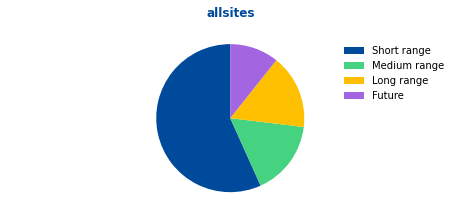

In [69]:
pie_chart(route_feasibility.loc['Trailer 86 13.6m'].values, route_feasibility.columns, 'allsites', folder="tru", suff='_battery_86trailer',
              title_text=None, labeldistance=None)

In [50]:
route_feasibility.columns

Index(['Short range', 'Medium range', 'Long range', 'Future'], dtype='object', name='battery_choice')

In [58]:
max_demand_perspec = pd.concat([vehicle_specifications['shorepower_summer_kw'],
           routes_cleaned.groupby('spec_id')['vehicle_id'].nunique()],
          axis=1)
max_demand_perspec['max_possible_kw'] = max_demand_perspec['shorepower_summer_kw'] * max_demand_perspec['vehicle_id']
max_demand_perspec.sum()

shorepower_summer_kw      16.79
vehicle_id              2169.00
max_possible_kw         7356.06
dtype: float64

In [66]:
mask_site = routes_cleaned['site_id_end'] == 1
weight_site = (routes_cleaned[mask_site].groupby('spec_id').count()['route_id']  /mask_site.sum())

In [68]:
(vehicle_specifications['shorepower_summer_kw'] * weight_site).sum()

3.5422129929177233

In [ ]:
ff.plot_stacked_bar(route_feasibility/total_routes, folder='tru', x_axis='spec_id',
                 title_text='eTRU Battery feasibility', site_name='all',
                 y_axis=r'% routes', suff=f'_{season}')
ff.plot_grouped_histo(routes_cleaned, 'route_kwh', specs, 'spec_id', good_specs,
                   folder='tru', site_name='all',
                   bins=np.arange(0,26, step=2),
                   title_text=f'eTRU energy requirement - {season}',
                   vline_dict=tru_battery_dict, plot_mean=False,
                   suff=f'_{season}', ylim=[0, 55000])

In [73]:
departures_per_day = routes_cleaned.groupby(['site_id_start', 'date'])[['route_id']].count()
max_daily_departures = departures_per_day.groupby('site_id_start').max()
max_daily_departures['site_name'] = max_daily_departures.index.map(site_dict)
# max_daily_departures.loc[good_sites]

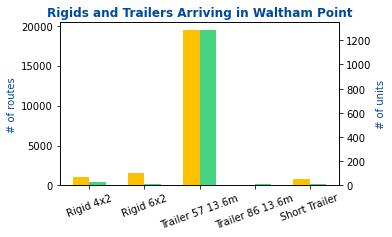

In [112]:
# Number of routes and units

site_routes = routes_cleaned[routes_cleaned['site_id_end'] == 1]
grouped = site_routes.groupby('spec_id').agg({'vehicle_id': 'nunique', 'route_id': 'count'})
fig, ax = plt.subplots(
    1, figsize=(5, 3), gridspec_kw={'hspace': 0.5})
ax.set_title(
    f'Rigids and Trailers Arriving in Waltham Point',
    color=FPS_COLOURS[0], fontweight='bold')
x = np.arange(len(good_specs))
ax.bar(x=x-0.15, width=0.3,
       height=grouped['route_id'], color=FPS_COLOURS[2])
ax2 = ax.twinx()
ax2.bar(x=x+0.15, width=0.3,
       height=grouped['vehicle_id'], color=FPS_COLOURS[1])
ax.set_ylabel('# of routes', color=FPS_COLOURS[0])
ax2.set_ylabel('# of units', color=FPS_COLOURS[0])
ax.set_xticks(x, labels=grouped.index.map(good_specs))
ax.set_xticklabels(labels=grouped.index.map(good_specs), rotation = 20)
fig.savefig(
    f"sample/tru/wp_routes_per_group.png",
    bbox_inches="tight", dpi=300)

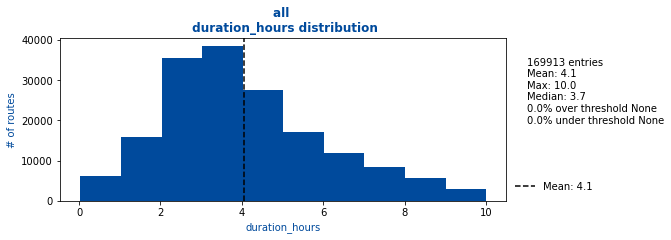

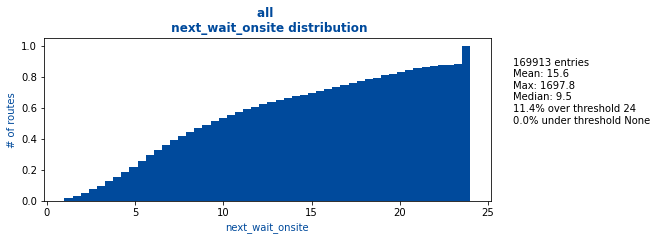

In [15]:
ff.histo_variable(routes_cleaned, 'duration_hours', 'all', upperclip=None,
                   lowerclip=None, bins=10, folder="tru",
                   suff='', title_text=None,
                   plot_mean=True)
ff.histo_variable(routes_cleaned, 'next_wait_onsite', 'all', upperclip=24,
                   lowerclip=None, bins=50, folder="tru",
                   suff='', title_text=None,
                   plot_mean=False, cumdist=True)

### Daily duties

In [ ]:
duty_wait_time = 4
routes_cleaned.sort_values(by=['vehicle_id', 'departure_time'],
                        inplace=True)
routes_cleaned['new_vehicle'] = routes_cleaned['vehicle_id'] != routes_cleaned['vehicle_id'].shift(1)
routes_cleaned['new_duties'] = ((routes_cleaned['new_vehicle'])
                                | (routes_cleaned['last_wait_onsite'] > duty_wait_time))
routes_cleaned['duty_id'] = routes_cleaned['new_duties'].cumsum()

daily_duties = routes_cleaned.groupby(['duty_id']).agg({
    'departure_time': 'min',
    'site_id_start': ['first', 'nunique'],
    'distance_miles': 'sum',
    'duration_hours': 'sum',
    'number_order': 'sum',
    'arrival_time': 'max',
    'route_id': 'count',
    'site_id_end': 'last',
    'spec_id': 'mean',
    'vehicle_id': 'mean',
    'date': 'first',
    'start_time': 'min',
    'end_time': 'max'})
daily_duties.columns = ['departure_time', 'site_id_start', 'number_sites', 'distance_miles',
                        'route_hours', 'number_order', 'arrival_time', 'n_routes', 'site_id_end',
                        'spec_id', 'vehicle_id', 'date', 'start_time', 'end_time']#
daily_duties['same_return'] = daily_duties['site_id_start'] == daily_duties['site_id_end']
daily_duties['duty_duration'] = (daily_duties['arrival_time'] - daily_duties['departure_time']).dt.total_seconds()/3600

duties_selection_dict = {
    'departure_time': 'min',
    'site_id_start': ['first', 'nunique'],
    'distance_miles': 'sum',
    'duration_hours': 'sum',
    'arrival_time': 'max',
    'route_id': 'count',
    'site_id_end': 'last',
    'spec_id': 'mean',
    'vehicle_id': 'mean',
    'date': 'first',
    'start_time': 'min',
    'end_time': 'max'}


In [ ]:
# This creates new breakpoints in the vehicle duties based on the longest break time back on the site

duty_hour_threshold = 25
duty_hour_min = dt.timedelta(hours=24)
long_duties = daily_duties[daily_duties['duty_duration'] > duty_hour_threshold].index.values
print(len(long_duties), len(daily_duties))
duty_route_cols = ['site_id_start', 'last_wait_onsite', 'new_duties', 'departure_time']
for duty in long_duties[:]:
    duty_routes = routes_cleaned[routes_cleaned['duty_id'] == duty][duty_route_cols]
    elapsed_time = duty_routes['departure_time'] - duty_routes['departure_time'].min()
    time_difference = (elapsed_time - duty_hour_min).dt.total_seconds().abs()
    possible_break_routes = ((duty_routes['site_id_start'].isin(good_sites))
                             & (~duty_routes['new_duties']))
    if possible_break_routes.any():
        break_route = time_difference.loc[possible_break_routes].idxmin()
        routes_cleaned.loc[break_route, 'new_duties'] = True

routes_cleaned['duty_id'] = routes_cleaned['new_duties'].cumsum()

daily_duties = routes_cleaned.groupby(['duty_id']).agg(duties_selection_dict)

daily_duties.columns = ['departure_time', 'site_id_start', 'number_sites', 'distance_miles',
                        'route_hours', 'arrival_time', 'n_routes', 'site_id_end',
                        'spec_id', 'vehicle_id', 'date', 'start_time', 'end_time']

daily_duties['duty_duration'] = (daily_duties['arrival_time'] - daily_duties['departure_time']).dt.total_seconds()/3600
long_duties = daily_duties[daily_duties['duty_duration'] > duty_hour_threshold].index.values
print(len(long_duties), len(daily_duties))

daily_duties['same_return'] = daily_duties['site_id_start'] == daily_duties['site_id_end']
daily_duties = daily_duties[daily_duties['duty_duration'] <= duty_hour_threshold]

### Total energy consumption

In [96]:
site_arrivals = routes_cleaned[routes_cleaned['site_id_end'].isin(good_sites)]
weekly_usage = site_arrivals.groupby(['week']).agg({
    'route_kwh': 'sum',
    'shorepower_kwh': 'sum',
    'route_id': 'count',
    'vehicle_id': 'nunique'})
weekly_usage['total_kwh_tru'] = weekly_usage['route_kwh']*0.72753923 + weekly_usage['shorepower_kwh']*0.639393939
weekly_usage.columns = ['route_kwh', 'shorepower_kwh', 'n_routes', 'n_vehicles', 'total_kwh_tru']
weekly_usage.to_csv('sample/tru/durations_all.csv')
weekly_usage

,route_kwh,shorepower_kwh,n_routes,n_vehicles,total_kwh_tru
week,,,,,
6,18382.811522,40785.420736,2442,1413,39452.167358
7,118937.376658,258117.466092,15546,1947,251570.350801
8,110771.663103,235486.509142,14468,1916,231159.377141
9,112837.027247,239423.070372,14740,1882,235179.023972
10,112336.605525,239662.498594,14640,1899,234968.036491
11,117068.164447,253094.331478,15379,1972,246998.663762
12,124902.137178,268378.334406,16422,1994,262470.685086
13,126780.148267,270205.275525,16373,1986,265005.146906
14,125407.424767,266474.907614,16203,1983,261621.262075


### Histos

In [ ]:
for spec_id in specs:
    routes_spec = routes[routes['spec_id'] == spec_id]
    ff.histo_variable(routes_spec, 'duration_hours', f'all_routes', suff=f"_{spec_id}",
                      folder="tru", title_text=f"All {good_specs[spec_id]} routes")
    ff.histo_variable(routes_spec, 'last_wait_onsite', f'all_routes', suff=f"_{spec_id}",
                      folder="tru", title_text=f"All {good_specs[spec_id]} routes",
                      upperclip=12, plot_mean=False)

### Route analysis

In [ ]:
ff.histo_variable(routes, 'start_time', f'all_routes', suff=f"",
                    folder="tru", title_text=f"Start times all sites",
                    plot_mean=False)

In [ ]:
daily = routes.groupby(['vehicle_id', 'date']).agg({'client_id': 'count', 'spec_id': 'min'})
daily.groupby('spec_id').mean()

In [ ]:
routes_to_site = routes[routes['site_id_end'] == 1]
ff.histo_variable(routes_to_site, 'duration_hours', f'all_routes', suff=f"_WP",
                    folder="tru", title_text=f"All spec at WP",
                    upperclip=12, plot_mean=False)

In [ ]:
routes_from_site = routes[routes['site_id_start'] == 1]
ff.histo_variable(routes_from_site, 'last_wait_onsite', f'all_routes', suff=f"_WP",
                    folder="tru", title_text=f"All spec at WP",
                    upperclip=12, plot_mean=False)

## Little bits

### Fix specs

In [ ]:
# hgv_assets = pd.read_csv(r"C:\Users\SofiaTaylor\OneDrive - Flexible Power Systems Ltd\Consulting\SSL\22-03.SSL.depot_asset_register.MA.02.csv",
#                          usecols=['Fleet Reg No', 'new_spec_id'], index_col='Fleet Reg No')
# hgv_spec_dict = hgv_assets['new_spec_id'].to_dict()
# cnx = dbh.create_alch_engine()
# sql_query = f"SELECT * FROM t_vehicles WHERE client_id=2 AND spec_id=100"
# vehicle_df = pd.read_sql_query(sql_query, con=cnx, index_col='vehicle_id')
# weird_float_str = vehicle_df['client_vehicle_id'].str[-2:] == ".0"
# vehicle_df.loc[weird_float_str, 'client_vehicle_id'] = vehicle_df.loc[weird_float_str, 'client_vehicle_id'].str[:4]
# vehicle_df['spec_id'] = vehicle_df['client_vehicle_id'].map(hgv_spec_dict)
# vehicle_df['spec_id'] = vehicle_df['spec_id'].fillna(0).astype(int)
# vehicle_spec_dict = vehicle_df['spec_id'].to_dict()
# dbh.upload_table(vehicle_df.reset_index(), 't_vehicles')